In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def select_roi (image):
    fromCenter = False
    showCrosshair = False
    r = cv2.selectROI(image, fromCenter, showCrosshair)
    return r
def crop_image (image, r):
    imCrop = image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
    return imCrop
def display_image (name , image):
    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [2]:
import cv2
from scipy import stats

path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Sp/Imagenes_confocal/Rata/C071112/'
photo_name = 'c2ac009'
image = cv2.imread(path + photo_name + ".tif",0)    # Read image

In [3]:
display_image(photo_name,image)

In [4]:
r = select_roi (image) # Select ROI
imCrop = crop_image (image, r)    # Crop image
display_image ('Image' , imCrop)    # Display cropped image

In [5]:
umbral=75 #arbitrario
blur = cv2.GaussianBlur(image,(7,7),0)
# img_equalizada = cv2.equalizeHist(blur)

# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(5,5))
cl1 = clahe.apply(blur)

binaria=(cl1>=umbral)
print(type(binaria[0,0]))
binaria=255*binaria.astype('uint8')
print(type(binaria[0,0]))

<class 'numpy.bool_'>
<class 'numpy.uint8'>


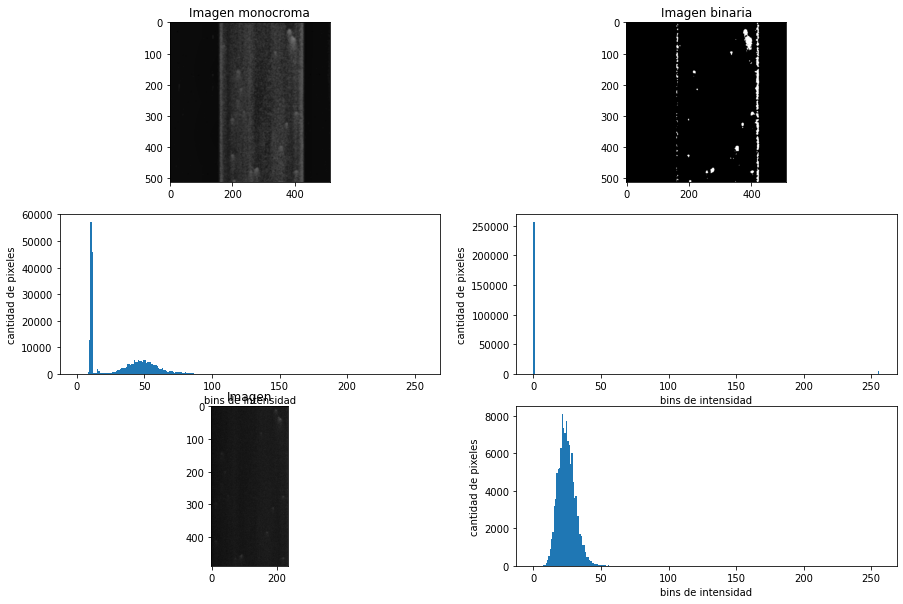

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False)
axs=axs.ravel()
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0].imshow(cl1, cmap='gray',vmin=0 ,vmax=255)
axs[0].set_title('Imagen monocroma')
axs[1].imshow(binaria, cmap='gray',vmin=0 ,vmax=255)
axs[1].set_title('Imagen binaria')
axs[2].hist(cl1[:,:].ravel(), 256,[0,256] ) 
axs[2].set_xlabel('bins de intensidad')
axs[2].set_ylabel('cantidad de pixeles')
axs[3].hist(binaria[:,:].ravel(), 256,[0,256] ) 
axs[3].set_xlabel('bins de intensidad')
axs[3].set_ylabel('cantidad de pixeles')
axs[4].imshow(imCrop, cmap='gray',vmin=0 ,vmax=255)
axs[4].set_title('Imagen')
axs[5].hist(imCrop[:,:].ravel(), 256,[0,256] ) 
axs[5].set_xlabel('bins de intensidad')
axs[5].set_ylabel('cantidad de pixeles')
plt.show()

In [8]:
def find_contourns (image):
    cnts = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    return cnts
def track_contours (c, image, original, track_number):
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255,255,0), 2)
    cv2.putText(image, str(track_number), (x-2, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0),2)
    ROI = original[y:y+h, x:x+w]
    x_data = np.asarray(range(x,x+w),dtype=np.float64)
    #análisis de cada spark
    SI = Image.fromarray(ROI.astype(np.uint8))
    img_col_mean = np.mean(SI,axis=0) #lista de datos del histograma por columna
    img_row_mean = np.mean(SI,axis=1) #lista de datos del histograma por fila
    img_col_mean = [x.mean() for x in img_col_mean]
    img_row_mean = [x.mean() for x in img_row_mean]
    return img_row_mean , img_col_mean
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=10):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 400

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha


    # Calculate new histogram with desired range and show histogram
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

In [ ]:
cnts = find_contourns (cl1)    # Find contours

# Iterate thorugh contours and filter for ROI
list_img_col = []
list_img_row = []
track_number = 0
for c in cnts:
    img_mean = track_contours (c, cl1, image, track_number)
    img_col_mean = img_mean [0]
    img_row_mean = img_mean [1]
    track_number +=1
    list_img_col.append (img_col_mean)
    list_img_row.append (img_row_mean)
display_image ('image' , cl1)

# if list_img:
#     list_img_col = list_img [0]
#     list_img_row = list_img [1]
#     out_sparks = analysis_process (list_img_col, list_img_row)